## Creating Customer Segments (Unsupervised Learning)
##### Raghavendra Prasad Savada

## Table of Contents

* [Introduction](#intro)
* [Data Exploration](#step0)
* [Data Preprocessing](#step1)
    * [Feature Scaling](#step2) 
    * [Outlier Detection](#step3)
* [Feature Transformation](#step4)
    * [PCA](#step5)
    * [Visualizing a Biplot](#step6)
* [Clustering](#step7)
    * [Cluster Visualization](#step8)
    * [Visualizing Underlying Distribution](#step9)
* [References](#step10)

---
<a id='intro'></a>
## Introduction

In this project, I will analyze data on annual spending of various customers of a wholesale distributor in Lisbon, Portugal on diverse product categories. The goal of this project is to best describe the variation in the different types of customers and to understand internal structure in the data to create customer segments. Doing so would equip the distributor with insight into how to best structure their delivery service based on customer segments.

The dataset for this project can be found on the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Wholesale+customers). For the purposes of this project, the features `'Channel'` and `'Region'` will be excluded in the analysis — with focus instead on the six product categories recorded for customers.

In the code block below I have loaded the wholesale customers dataset, along with a few of the necessary Python libraries required for this project. 

In [1]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from IPython.display import display # Allows the use of display() for DataFrames

# Import supplementary visualizations code visuals.py
import visuals as vs

# Pretty display for notebooks
%matplotlib inline

# Load the wholesale customers dataset
try:
    data = pd.read_csv("customers.csv")
    data.drop(['Region', 'Channel'], axis = 1, inplace = True)
    print("Wholesale customers dataset has {} samples with {} features each.".format(*data.shape))
except:
    print("Dataset could not be loaded. Is the dataset missing?")

Wholesale customers dataset has 440 samples with 6 features each.


---
<a id='step0'></a>
## Data Exploration

In the code block below, I have provided a statistical description of the dataset. Note that the dataset is composed of six important product categories: **'Fresh'**, **'Milk'**, **'Grocery'**, **'Frozen'**, **'Detergents_Paper'**, and **'Delicatessen'**. 

In [2]:
# Display a description of the dataset
display(data.describe())
data.head()


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
0,12669,9656,7561,214,2674,1338
1,7057,9810,9568,1762,3293,1776
2,6353,8808,7684,2405,3516,7844
3,13265,1196,4221,6404,507,1788
4,22615,5410,7198,3915,1777,5185


#### Selecting Samples
To get a better understanding of the customers and how their data will transform through the analysis, in the code block below, I have selected three sample data points that vary significantly from one another. I will explore them in more detail as I go through the analysis.

In [3]:
import random

#Select three indices for sample datapoints
indices = [92, 322, 378] # indeces were selected using the line `random.sample(range(440), 3)` to try different samples 
# to obtain a sample where each of the three items vary significantly from one another

# Create a DataFrame of the chosen samples
samples = pd.DataFrame(data.loc[indices], columns = data.keys()).reset_index(drop = True)
print("Chosen samples of wholesale customers dataset:")
display(samples)

Chosen samples of wholesale customers dataset:


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
0,9198,27472,32034,3232,18906,5130
1,15881,713,3315,3703,1470,229
2,3225,3294,1902,282,68,1114


#### Feature Relevance
One interesting thought to consider is if it is possible to determine whether customers purchasing some amount of one category of products will necessarily purchase some proportional amount of another category of products. We can make this determination quite easily by training a supervised regression learner on a subset of the data with one feature removed, and then score how well that model can predict the removed feature.

In the code block below, I have implemented the following:
 - Assigned `new_data` a copy of the data by removing a feature of choice using the `DataFrame.drop` function.
 - Used `sklearn.cross_validation.train_test_split` to split the dataset into training and testing sets.
   - Used the removed feature as my target label. Set a `test_size` of `0.25` and set a `random_state`.
 - Imported a decision tree regressor, set a `random_state`, and fit the learner to the training data.
 - Reported the prediction score of the testing set using the regressor's `score` function.

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor

# Make a copy of the DataFrame, using the 'drop' function to drop the given feature
new_data = data.drop(['Detergents_Paper'], axis =1)
target = data['Detergents_Paper']
score_dic = {'droped_feature': [], 'coeffcient_of_determination': []}

for i in data.columns:
    new_data = data.drop(i, axis =1)
    target = data[i]


    # Split the data into training and testing sets(0.25) using the given feature as the target
    X_train, X_test, y_train, y_test = train_test_split(new_data, target, random_state = 42, test_size = 0.25)

    # Create a decision tree regressor and fit it to the training set
    regressor = DecisionTreeRegressor(random_state=42)
    regressor.fit(X_train, y_train)

    # Report the score of the prediction using the testing set

    score = regressor.score(X_test, y_test)
    score_dic['droped_feature'].append(i)
    score_dic['coeffcient_of_determination'].append(score)

pd.DataFrame(score_dic)   

,coeffcient_of_determination,droped_feature
0,-0.385750,Fresh
1,0.156275,Milk
2,0.681884,Grocery
3,-0.210136,Frozen
4,0.271667,Detergents_Paper
5,-2.254712,Delicatessen


I attempted to predict all the features one-by-one. R^2 is the highest when I drop the feature Grocery (R^2 =0.68). Is it a high R^2 score? What is good R^2 in one field of study may be considered as low in other fields of study. I would say, in this case, R^2 of 0.68 is low, beccause the other 5 features still can not explain 32% variance in the Grocery feature. This unexplained variance may be useful in identifying patterns in customers' spendings. So I would include this, and all other features in my furhter analysis. 

It should be noted that, when I drop the other features, prediction score (R^2) was very low ranging from -2.3 to 0.27.

Note: The coefficient of determination, `R^2` is scored between 0 and 1, with 1 being a perfect fit. A negative `R^2` implies the model fails to fit the data. If you get a low score for a particular feature, that lends us to beleive that the feature point is hard to predict using the other features, thereby making it an important feature to consider when considering relevance.

#### Visualize Feature Distributions
To get a better understanding of the dataset, we can construct a scatter matrix of each of the six product features present in the data. If the feature is relevant for identifying a specific customer, then the scatter matrix below may not show any correlation between that feature and the others. Conversely, if the feature is not relevant for identifying a specific customer, the scatter matrix might show a correlation between that feature and another feature in the data. 

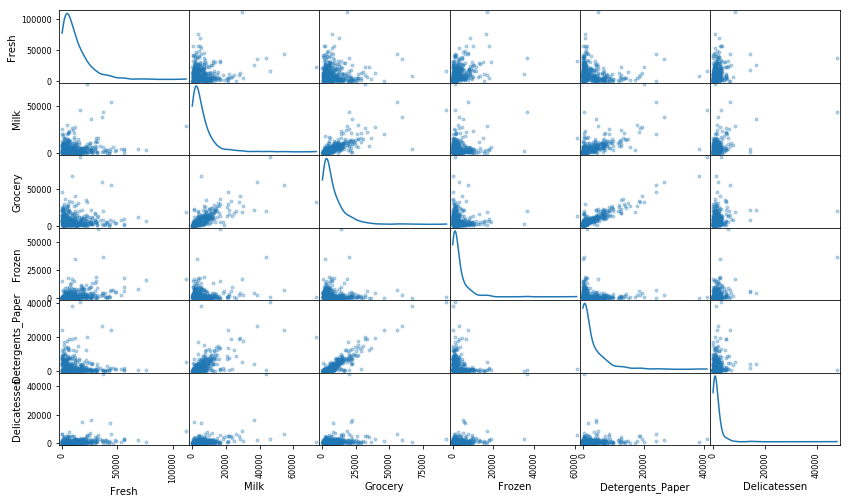

In [5]:
# Produce a scatter matrix for each pair of features in the data
pd.scatter_matrix(data, alpha = 0.3, figsize = (14,8), diagonal = 'kde');

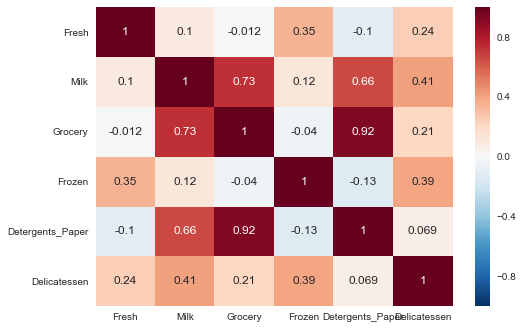

In [6]:
import seaborn as sns
sns.heatmap(data.corr(), annot=True);

All the six features are right skewed. This is common in this kind of data as the minimum value taken by these variables are bound by 0, but on the other side there are some outliers that takes a very large values. 

The following pair of variables exhibit quite a strong correlation.

Grocery:Detergent Papers - r = 0.92 

Grocery:Milk - r = 0.73

Detergent Paper:Milk - r = 0.66

First two pairs above conform to the results obtained in the Feature Relevance section as 68% variance in Grocery feature could be explained by the rest of the features. However, the last pair above is bit surprising because less than 30% of variance in Detergent Paper or Milk could be explained by the rest of the variables.

It is noteworthy that if I had used simple linear regression, the variable Detergent_Papers alone could have explained 81% variance in Grocery (r = 0.92, R^2 = 0.85). However, when I tried to predict Grocery using all the remaining five variables using decision tree regressor, only 68% variance in Grocery could be explained. This probably shows why we should not add unnecessary branches to a decision tree.

---
<a id='step1'></a>
## Data Preprocessing
In this section, I will preprocess the data to create a better representation of customers by performing a scaling on the data and detecting and removing (if necessary) outliers. Preprocessing data is often times a critical step in assuring that results we obtain from our analysis are significant and meaningful.

---
<a id='step2'></a>
### Feature Scaling
If data is not normally distributed, especially if the mean and median vary significantly (indicating a large skew), it is most often appropriate to apply a [non-linear scaling](http://econbrowser.com/archives/2014/02/use-of-logarithms-in-economics) — particularly for financial data. One way to achieve this scaling is by using a [Box-Cox test](http://scipy.github.io/devdocs/generated/scipy.stats.boxcox.html), which calculates the best power transformation of the data that reduces skewness. A simpler approach which can work in most cases would be applying the natural logarithm.

In the code block below, I have implemented the following:
 - Assigned a copy of the data to `log_data` after applying logarithmic scaling. Used the `np.log` function for this.
 - Assigned a copy of the sample data to `log_samples` after applying logarithmic scaling. Again, used `np.log`.
 
After applying a natural logarithm scaling to the data, the distribution of each feature appear much more normal (see plots below). 

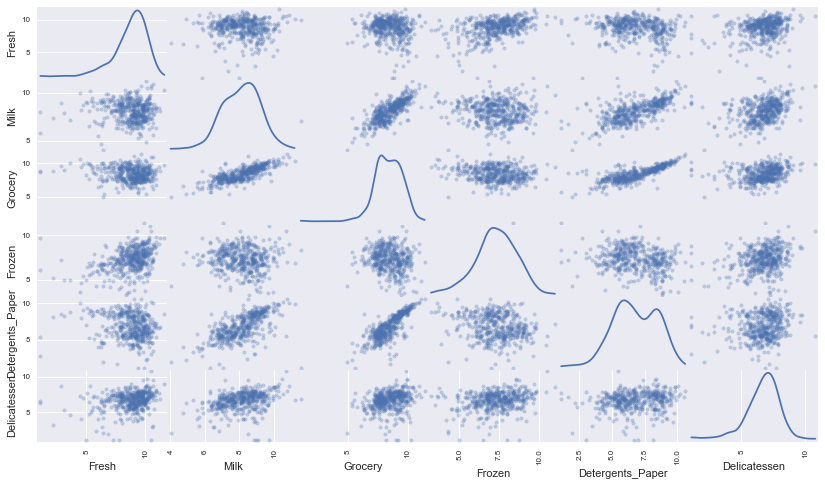

In [7]:
# Scale the data using the natural logarithm
log_data = np.log(data)

# Scale the sample data using the natural logarithm
log_samples = np.log(samples)

# Produce a scatter matrix for each pair of newly-transformed features
pd.scatter_matrix(log_data, alpha = 0.3, figsize = (14,8), diagonal = 'kde');

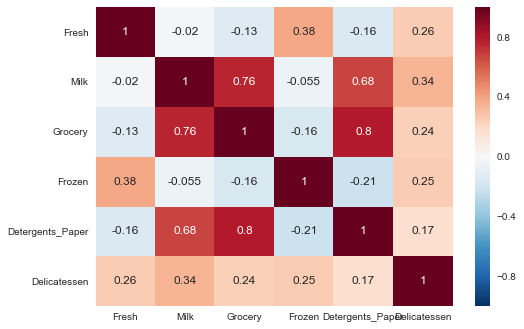

In [8]:
sns.heatmap(log_data.corr(), annot=True);

In [9]:
# Display the log-transformed sample data
display(log_samples)

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
0,9.126741,10.220923,10.374553,8.080856,9.847235,8.542861
1,9.672879,6.569481,8.106213,8.216899,7.293018,5.433722
2,8.078688,8.099858,7.550661,5.641907,4.219508,7.015712


#### Difference between scaling by Box-Cox and natural log

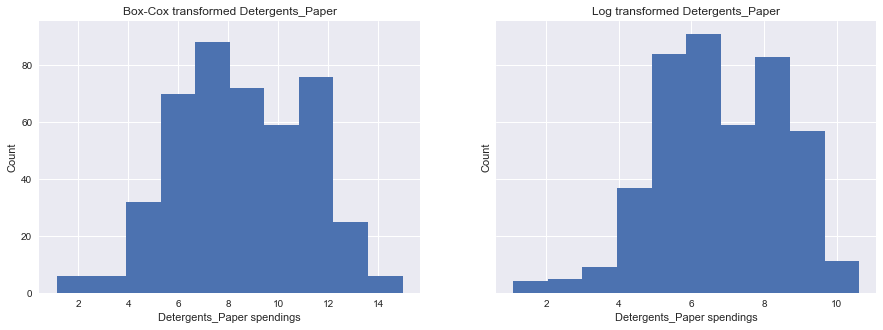

In [10]:
# Verify difference between scaling by Box-Cox and natural log using one of the features
import scipy
import matplotlib.pyplot as plt

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(15,5))

ax1.hist(pd.Series(scipy.stats.boxcox(data.Detergents_Paper)[0]))
ax1.set_title("Box-Cox transformed Detergents_Paper")
ax1.set_xlabel("Detergents_Paper spendings")          
ax1.set_ylabel("Count") 

ax2.hist(log_data.Detergents_Paper)
ax2.set_title("Log transformed Detergents_Paper")
ax2.set_xlabel("Detergents_Paper spendings")          
ax2.set_ylabel("Count") ;

**Note: **Box-Cox transfomration seems to be more efficient in reducing skewness than log transformation. However, I am going ahead with simpler log transformation as the difference is not that significant.

---
<a id='step3'></a>
### Outlier Detection
Detecting outliers in the data is extremely important in the data preprocessing step of any analysis. The presence of outliers can often skew results which take into consideration these data points. There are many "rules of thumb" for what constitutes an outlier in a dataset. Here, I will use [Tukey's Method for identfying outliers](http://datapigtechnologies.com/blog/index.php/highlighting-outliers-in-your-data-with-the-tukey-method/): An *outlier step* is calculated as 1.5 times the interquartile range (IQR). A data point with a feature that is beyond an outlier step outside of the IQR for that feature is considered abnormal.

In the code block below, I have implementd the following:
 - Assigned the value of the 25th percentile for the given feature to `Q1`. Used `np.percentile` for this.
 - Assigned the value of the 75th percentile for the given feature to `Q3`. Again, used `np.percentile`.
 - Assigned the calculation of an outlier step for the given feature to `step`.

In [11]:
# For each feature find the data points with extreme high or low values
outlier_indeces = []
for feature in log_data.keys():
    
    # Calculate Q1 (25th percentile of the data) for the given feature
    Q1 = np.percentile(log_data[[feature]], 25)
    
    # Calculate Q3 (75th percentile of the data) for the given feature
    Q3 = np.percentile(log_data[[feature]], 75)
    
    # Use the interquartile range to calculate an outlier step (1.5 times the interquartile range)
    step = (Q3-Q1)*1.5
    
    # Display the outliers
    print("Data points considered outliers for the feature '{}':".format(feature))
    outlier_df = log_data[~((log_data[feature] >= Q1 - step) & (log_data[feature] <= Q3 + step))]
    display(outlier_df)
    outlier_indeces += list(outlier_df.index)

print (pd.Series(outlier_indeces).value_counts())

# Select the indices for data points and add them to the following list if you want to remove them. 
# If you do not want to remove any outliers, please leave outliers as empty list
outliers  = []

# Remove the outliers, if any were specified
good_data = log_data.drop(log_data.index[outliers]).reset_index(drop = True)

Data points considered outliers for the feature 'Fresh':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
65,4.442651,9.950323,10.732651,3.583519,10.095388,7.260523
66,2.197225,7.335634,8.911530,5.164786,8.151333,3.295837
81,5.389072,9.163249,9.575192,5.645447,8.964184,5.049856
95,1.098612,7.979339,8.740657,6.086775,5.407172,6.563856
96,3.135494,7.869402,9.001839,4.976734,8.262043,5.379897
128,4.941642,9.087834,8.248791,4.955827,6.967909,1.098612
171,5.298317,10.160530,9.894245,6.478510,9.079434,8.740337
193,5.192957,8.156223,9.917982,6.865891,8.633731,6.501290
218,2.890372,8.923191,9.629380,7.158514,8.475746,8.759669
304,5.081404,8.917311,10.117510,6.424869,9.374413,7.787382


Data points considered outliers for the feature 'Milk':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
86,10.039983,11.205013,10.377047,6.894670,9.906981,6.805723
98,6.220590,4.718499,6.656727,6.796824,4.025352,4.882802
154,6.432940,4.007333,4.919981,4.317488,1.945910,2.079442
356,10.029503,4.897840,5.384495,8.057377,2.197225,6.306275


Data points considered outliers for the feature 'Grocery':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
75,9.923192,7.036148,1.098612,8.390949,1.098612,6.882437
154,6.432940,4.007333,4.919981,4.317488,1.945910,2.079442


Data points considered outliers for the feature 'Frozen':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
38,8.431853,9.663261,9.723703,3.496508,8.847360,6.070738
57,8.597297,9.203618,9.257892,3.637586,8.932213,7.156177
65,4.442651,9.950323,10.732651,3.583519,10.095388,7.260523
145,10.000569,9.034080,10.457143,3.737670,9.440738,8.396155
175,7.759187,8.967632,9.382106,3.951244,8.341887,7.436617
264,6.978214,9.177714,9.645041,4.110874,8.696176,7.142827
325,10.395650,9.728181,9.519735,11.016479,7.148346,8.632128
420,8.402007,8.569026,9.490015,3.218876,8.827321,7.239215
429,9.060331,7.467371,8.183118,3.850148,4.430817,7.824446
439,7.932721,7.437206,7.828038,4.174387,6.167516,3.951244


Data points considered outliers for the feature 'Detergents_Paper':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
75,9.923192,7.036148,1.098612,8.390949,1.098612,6.882437
161,9.428190,6.291569,5.645447,6.995766,1.098612,7.711101


Data points considered outliers for the feature 'Delicatessen':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
66,2.197225,7.335634,8.911530,5.164786,8.151333,3.295837
109,7.248504,9.724899,10.274568,6.511745,6.728629,1.098612
128,4.941642,9.087834,8.248791,4.955827,6.967909,1.098612
137,8.034955,8.997147,9.021840,6.493754,6.580639,3.583519
142,10.519646,8.875147,9.018332,8.004700,2.995732,1.098612
154,6.432940,4.007333,4.919981,4.317488,1.945910,2.079442
183,10.514529,10.690808,9.911952,10.505999,5.476464,10.777768
184,5.789960,6.822197,8.457443,4.304065,5.811141,2.397895
187,7.798933,8.987447,9.192075,8.743372,8.148735,1.098612
203,6.368187,6.529419,7.703459,6.150603,6.860664,2.890372


154    3
66     2
75     2
128    2
65     2
183    1
81     1
412    1
218    1
343    1
86     1
109    1
193    1
142    1
325    1
420    1
187    1
203    1
137    1
264    1
338    1
161    1
96     1
353    1
57     1
184    1
439    1
289    1
305    1
304    1
175    1
429    1
145    1
171    1
233    1
285    1
38     1
357    1
356    1
355    1
98     1
95     1
dtype: int64


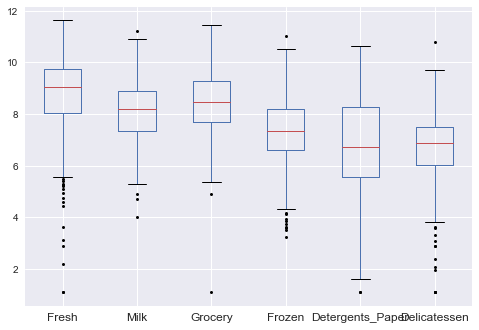

In [12]:
log_data.boxplot(figsize = (10, 5), sym = 'k.');

The data point with index 154 is considered outlier for three features. This customer is outlier in categories Grocery, Milk, and Delicatessen and their annual spending is less than 0.25 quantile. I guess, this customer could be a very small cafe.  The data points with indeces 65, 66, 75, and 128 are considered outliers for two features. 37 data points are outlier for one feature.

I have decided not to remove any of these outliers for the following reasons:

- All these data points seem to be legitimate and not due to any error in data entry.
- There are only three outlier data points that are above upper fence, but are very close to the fence (just little more than Q3 + 1.5 * IQR). So I chose not to remove these points.
- In features, **Fresh, Frozen and Delicatessen** there are quite a few data points that are below lower fence. However these points are evenly distributed and may form a cluster on their own. The outliers below lower fence in **Milk and Detergent_Papers** are quite close to fence.
- Initially, I thought of removing the data point with row index 75, as this point is more than 4xIQR away from 0.25 quantile in the feature Grocery. But on closer inspection, this customer seems to be a fresh procude seller who also carry very small quantities of convinience items. Therefore this data point may be an interesting one and may be valuable in forming a cluster of this kind of customers whose main focus is Fresh produce. 

---
<a id='step4'></a>
## Feature Transformation
In this section, I will use principal component analysis (PCA) to draw conclusions about the underlying structure of the wholesale customer data. Since using PCA on a dataset calculates the dimensions which best maximize variance, we will find which compound combinations of features best describe customers.

---
<a id='step5'></a>
### PCA

Now that the data has been scaled to a more normal distribution, we can apply PCA to the `good_data` to discover which dimensions of the data best maximize the variance of features involved. In addition to finding these dimensions, PCA will also report the *explained variance ratio* of each dimension — how much variance within the data is explained by that dimension alone. Note that a component (dimension) from PCA can be considered a new "feature" of the space, however it is a composition of the original features present in the data.

In the code block below, I have implemented the following:
 - Imported `sklearn.decomposition.PCA` and assigned the results of fitting PCA in six dimensions with `good_data` to `pca`.
 - Applied a PCA transformation of `log_samples` using `pca.transform`, and assigned the results to `pca_samples`.

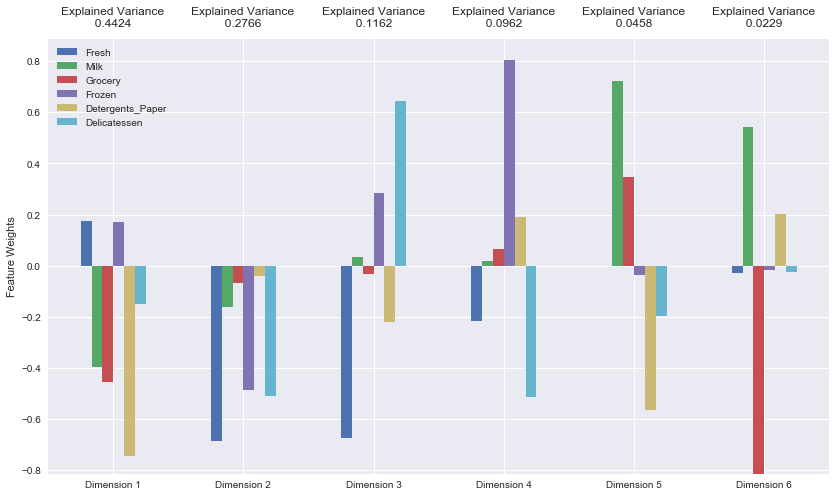

In [13]:
# Apply PCA by fitting the good data with the same number of dimensions as features
from sklearn.decomposition import PCA

pca = PCA(n_components=6, random_state = 42)
pca = pca.fit(good_data)

# Transform log_samples using the PCA fit above
pca_samples = pca.transform(log_samples)

# Generate PCA results plot
pca_results = vs.pca_results(good_data, pca)

In [14]:
dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]
components = pd.DataFrame(np.round(pca.components_, 4), columns = list(good_data.keys()))
components.index = dimensions
components

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
Dimension 1,0.1737,-0.3945,-0.4544,0.1722,-0.7455,-0.1494
Dimension 2,-0.6851,-0.1624,-0.0694,-0.4877,-0.0419,-0.5097
Dimension 3,-0.6735,0.0331,-0.0322,0.2848,-0.2182,0.6446
Dimension 4,-0.2143,0.0186,0.0645,0.8061,0.1901,-0.5135
Dimension 5,-0.0008,0.7223,0.3480,-0.0362,-0.5637,-0.1954
Dimension 6,-0.0293,0.5430,-0.8139,-0.0174,0.2024,-0.0228


- 72% of the variance in the data is explained in total by the first and second principal component.
- 93% of the variance in the data is explained by the first four principal components? 

The larger the absolute value of the coefficient for a variable, the more important the variable is in calculating the component. How large the absolute value of a coefficient has to be in order to deem it important is subjective ([Reference 1](https://support.minitab.com/en-us/minitab/18/help-and-how-to/modeling-statistics/multivariate/how-to/principal-components/interpret-the-results/all-statistics-and-graphs/)). Here, I have considered absolute value of 0.5 as large enough. 

1) The variable Detergents_Papers is well represented in the first principal component (Dimension 1), which has a large negative association with Detergents_papers.

2) The variables Fresh and Delicatessen are well represented in the second principal component, which has a large negative association with these variables.

3) The variables Fresh and Delicatessen are well represented in the third principal component also, which has a large negative and positive association with these variables, respectively.

4) The variables Frozen and Delicatessen are well represented in the fourth principal component, which has a large positive and negative association with these variables, respectively.

In summary, the variables customer spendings on Detergents_Papers, Fresh, Frozen and Delicatessen are well represented in first four principal components if I take 0.5 as the cutoff for absoulute coefficient value. However, it should be noted that first principal component has fairly good negative association with Milk (-0.3945) and Grocery (-0.4544) as well.

Cumulative variance explained by each of the dimension is as follows:

| Dimension | variance explained (%) | Cumulative variance explaned (%)|
|-----------|------------------------|---------------------------------|
|     1     |          44            |               44                | 
|     2     |          28            |               72                | 
|     3     |          12            |               84                | 
|     4     |          09            |               93                | 
|     5     |          05            |               98                | 
|     6     |          02            |               100               | 

Below we can see how the log-transformed sample data has changed after having a PCA transformation applied to it in six dimensions. 

In [15]:
# Display sample log-data after having a PCA transformation applied
print(log_samples)
display(pd.DataFrame(np.round(pca_samples, 4), columns = pca_results.index.values))

      Fresh       Milk    Grocery    Frozen  Detergents_Paper  Delicatessen
0  9.126741  10.220923  10.374553  8.080856          9.847235      8.542861
1  9.672879   6.569481   8.106213  8.216899          7.293018      5.433722
2  8.078688   8.099858   7.550661  5.641907          4.219508      7.015712


,Dimension 1,Dimension 2,Dimension 3,Dimension 4,Dimension 5,Dimension 6
0,-4.0666,-2.2121,0.5046,0.3246,0.0686,0.1184
1,0.8916,-0.2105,-1.3189,1.2143,-1.3164,-0.4827
2,1.8749,1.2500,0.7804,-1.9236,1.1136,0.2338


#### Dimensionality Reduction
When using principal component analysis, one of the main goals is to reduce the dimensionality of the data — in effect, reducing the complexity of the problem. Dimensionality reduction comes at a cost: fewer dimensions used implies less of the total variance in the data is being explained. Because of this, the *cumulative explained variance ratio* is extremely important for knowing how many dimensions are necessary for the problem. Additionally, if a signifiant amount of variance is explained by only two or three dimensions, the reduced data can be visualized afterwards.

In the code block below, I have implemented the following:
 - Assigned the results of fitting PCA in two dimensions with `good_data` to `pca`.
 - Applied a PCA transformation of `good_data` using `pca.transform`, and assigned the results to `reduced_data`.
 - Applied a PCA transformation of `log_samples` using `pca.transform`, and assigned the results to `pca_samples`.

In [16]:
# Apply PCA by fitting the good data with only two dimensions
pca = PCA(n_components=2, random_state = 42)
pca = pca.fit(good_data)

# Transform the good data using the PCA fit above
reduced_data = pca.transform(good_data)

# Transform log_samples using the PCA fit above
pca_samples = pca.transform(log_samples)

# Create a DataFrame for the reduced data
reduced_data = pd.DataFrame(reduced_data, columns = ['Dimension 1', 'Dimension 2'])

pca.explained_variance_ratio_


array([ 0.44237417,  0.27657107])

#### Observation
In the code below, I explored how the log-transformed sample data has changed after having a PCA transformation applied to it using only two dimensions. It should be noted that values for the first two dimensions remains unchanged when compared to a PCA transformation in six dimensions.

In [17]:
# Display sample log-data after applying PCA transformation in two dimensions
display(pd.DataFrame(np.round(pca_samples, 4), columns = ['Dimension 1', 'Dimension 2']))

,Dimension 1,Dimension 2
0,-4.0666,-2.2121
1,0.8916,-0.2105
2,1.8749,1.2500


---
<a id='step6'></a>
### Visualizing a Biplot
A biplot is a scatterplot where each data point is represented by its scores along the principal components. The axes are the principal components (in this case `Dimension 1` and `Dimension 2`). In addition, the biplot shows the projection of the original features along the components. A biplot can help us interpret the reduced dimensions of the data, and discover relationships between the principal components and original features.

In the code cell below, I produced a biplot of the reduced-dimension data.

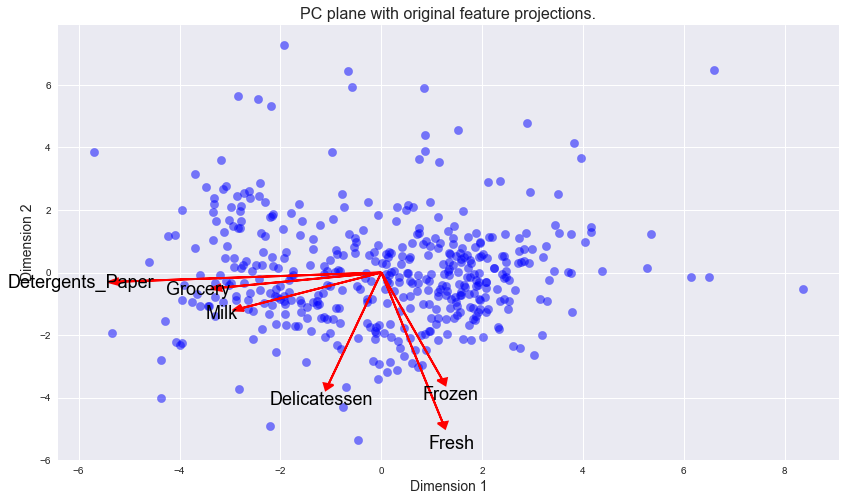

In [18]:
# Create a biplot
vs.biplot(good_data, reduced_data, pca)

#### Observation

Once we have the original feature projections (in red), it is easier to interpret the relative position of each data point in the scatterplot. Detergents_Paper is most strongly correlated with the first component, and Fresh is most strongly correlated with the second component.

---
<a id='step7'></a>
## Clustering

In this section, I will explore and choose between a K-Means clustering algorithm or a Gaussian Mixture Model clustering algorithm to identify the various customer segments hidden in the data. 

##### Advantages of K-means
- Easy to implement.
- It is likely to be computationally faster and efficient than other clustering methods when there are large number of features privided k is not very big; typically big O is number of clusters x number of features x number of samples.
- It is likely to produce tighter cluster.
- Easy to interpret results ([Reference 2](https://www.quora.com/What-are-the-advantages-of-K-Means-clustering)).

##### Advantages of Gaussian Mixture Model clustering algorithm 
- It provides soft clustering, in that, a sample can be a member of multiple clusters.
- It gives flexibility in the shapes of the cluster. For instace, a cluster containing another cluster inside of it ([Reference 3](https://classroom.udacity.com/nanodegrees/nd009t/parts/97af2e29-7ace-4288-8f00-7e7788c1c810/modules/d425790b-c3f4-4585-9e9b-299d608741df/lessons/75058ed7-ed1e-46b5-9aa2-3fe11da0d136/concepts/71a97c14-e970-47f0-9125-80d5ee5cfede)).


In hard clustering (e.g., K-Means), each data point either belongs to a cluster completely or not. Whereas in soft clustering (e.g., Gaussian Mixture Model), instead of putting each data point into a separate cluster, a probability or likelihood of that data point to be in those clusters is assigned ([Reference 4](https://www.analyticsvidhya.com/blog/2016/11/an-introduction-to-clustering-and-different-methods-of-clustering/)). 

I think, soft clustering is more suitable to cluster the customer spending data. Suppose, customers of this wholesale distributors belong to four different clusters. Then wholesale distributor design different delivery systems for different clusters. One day, due to some problem, they can not use the assigned delivery service to one of the customers. If we have used soft clustering, we can easily find out in which cluster this customer has the next highest membership, so that we can use the corresponding delivery system as an alternate plan. Soft clustering also gives the flexibility in assigning delivery system to customers that are at the boundary of the clusters.

#### Creating Clusters
Depending on the problem, the number of clusters that you expect to be in the data may already be known. When the number of clusters is not known *a priori*, there is no guarantee that a given number of clusters best segments the data, since it is unclear what structure exists in the data — if any. However, we can quantify the "goodness" of a clustering by calculating each data point's *silhouette coefficient*. The [silhouette coefficient](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html) for a data point measures how similar it is to its assigned cluster. Its value ranges from -1 (dissimilar) to 1 (similar). Calculating the *mean* silhouette coefficient provides for a simple scoring method of a given clustering.

In the code block below, I have implemented the following:
 - Fit the GaussianMixture algorithm to the `reduced_data` and assigned it to `clusterer`.
 - Predicted the cluster for each data point in `reduced_data` using `clusterer.predict` and assigned them to `preds`.
 - Found the cluster centers using the algorithm's `clusterer.means_` attribute and assigned them to `centers`.
 - Predicted the cluster for each sample data point in `pca_samples` and assigned them to `sample_preds`.
 - Imported `sklearn.metrics.silhouette_score` and calculateed the silhouette score of `reduced_data` against `preds`.
   - Assigned the silhouette score to `score` and printed the result.

In [19]:
# Apply clustering algorithm to the reduced data 
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

clusterer = GaussianMixture(n_components=3, random_state = 42).fit(reduced_data)

# Predict the cluster for each data point
preds = clusterer.predict(reduced_data)

# Find the cluster centers
centers = clusterer.means_

# Predict the cluster for each transformed sample data point
sample_preds = clusterer.predict(pca_samples)

# Calculate the mean silhouette coefficient for the number of clusters chosen
score = silhouette_score(reduced_data, preds)
print (score)

0.41057253381


#### Try different number of clusters and find out the number of clusters that has the best silhouette score.

In [20]:
def clustering_errors(k, data):
    gmm = GaussianMixture(n_components=k, random_state = 42).fit(data)
    predictions = gmm.predict(data)
    silhouette_avg = silhouette_score(data, predictions)
    return silhouette_avg

# Choose the range of number of components k values to test.
possible_k_values = [2, 3, 4, 5, 7, 10, 20, 40, 70, 100, 150]

#calculate silhouette_score
sil_scores = [clustering_errors(k, reduced_data) for k in possible_k_values]

The following table shows the silhouette score for several cluster numbers (or number of guassian distributions) I tried. Of these, n_components = 3 has the best silhouette score. 

In [21]:
# silhouette score for different n_components
pd.DataFrame(list(zip(possible_k_values, sil_scores)), columns = ['n_components', 'Silhouette Score'])

,n_components,Silhouette Score
0,2,0.409885
1,3,0.410573
2,4,0.302924
3,5,0.234385
4,7,0.353015
5,10,0.292086
6,20,0.328462
7,40,0.243422
8,70,0.277047
9,100,0.309804


---
<a id='step8'></a>
### Cluster Visualization
I have visualized the results of clustering in the code block below. 

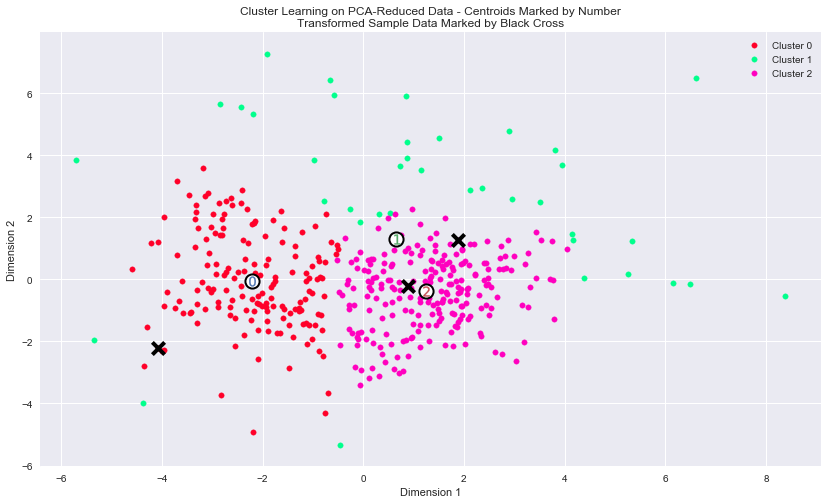

In [22]:
# Display the results of the clustering from implementation
vs.cluster_results(reduced_data, preds, centers, pca_samples)

#### Data Recovery
Each cluster present in the visualization above has a central point. These centers (or means) are not specifically data points from the data, but rather the *averages* of all the data points predicted in the respective clusters. For the problem of creating customer segments, a cluster's center point corresponds to *the average customer of that segment*. Since the data is currently reduced in dimension and scaled by a logarithm, we can recover the representative customer spending from these data points by applying the inverse transformations.

In the code block below, I have implemented the following:
 - Applied the inverse transform to `centers` using `pca.inverse_transform` and assigned the new centers to `log_centers`.
 - Applied the inverse function of `np.log` to `log_centers` using `np.exp` and assigned the true centers to `true_centers`.

In [23]:
# Inverse transform the centers
log_centers = pca.inverse_transform(centers)

# Exponentiate the centers
true_centers = np.exp(log_centers)

# Display the true centers
segments = ['Segment {}'.format(i) for i in range(0,len(centers))]
true_centers = pd.DataFrame(np.round(true_centers), columns = data.keys())
true_centers.index = segments
display(true_centers)

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
Segment 0,4414.0,8158.0,12750.0,1046.0,4636.0,1132.0
Segment 1,2822.0,2100.0,3142.0,875.0,514.0,364.0
Segment 2,9985.0,2198.0,2712.0,2213.0,358.0,793.0


In [24]:
data.describe()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


Representative customer spending on Grocery, Milk and Detergent_Papers in segment 0 is higher than average customer spending on these categories. So I think this segment represents retailers (e.g., superstore).

Representative customer spending on Grocery, Milk and Detergent_Papers in segment 1 and 2 is lower than average customer spending on these categories. So I think these segments may not represent large grocery stores/retailers. I think, segment 2 could be vendors who mostly focuses on fresh produce but also carry some convinience items. Segment 1 may be restaurants/cafes of various size.

The code block below shows which cluster each sample point is predicted to be in.

In [25]:
# Display the predictions
for i, pred in enumerate(sample_preds):
    print("Sample point", i, "predicted to be in Cluster", pred)

('Sample point', 0, 'predicted to be in Cluster', 0)
('Sample point', 1, 'predicted to be in Cluster', 2)
('Sample point', 2, 'predicted to be in Cluster', 2)


In [26]:
# Show the samples for easy comparison
samples

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
0,9198,27472,32034,3232,18906,5130
1,15881,713,3315,3703,1470,229
2,3225,3294,1902,282,68,1114


#### Unsupervised to Supervised Learning

Additional structure is derived from originally unlabeled data when using clustering techniques. Since each customer has a ***customer segment*** it best identifies with (depending on the clustering algorithm applied), we can consider *'customer segment'* as an **engineered feature** for the data. Assume the wholesale distributor recently acquired ten new customers and each provided estimates for anticipated annual spending of each product category. First, the wholesale distributor can train a model using supervised learning algorithm that is suitable for classification (e.g., decision tree). Customer spendings on 6 product cateogories in the above data set will be features and engineered feature customer_segment as identified by the chosen clustering algorithm will be the target variable. Then the model thus trained can be used to label the new customer using their estimated product spending.

---
<a id='step9'></a>
### Visualizing Underlying Distributions

At the beginning of this project, it was discussed that the `'Channel'` and `'Region'` features would be excluded from the dataset so that the customer product categories were emphasized in the analysis. By reintroducing the `'Channel'` feature to the dataset, an interesting structure emerges when considering the same PCA dimensionality reduction applied earlier to the original dataset.

As seen below each data point is labeled either `'HoReCa'` (Hotel/Restaurant/Cafe) or `'Retail'`. In addition, the sample points are circled in the plot, which will identify their labeling.

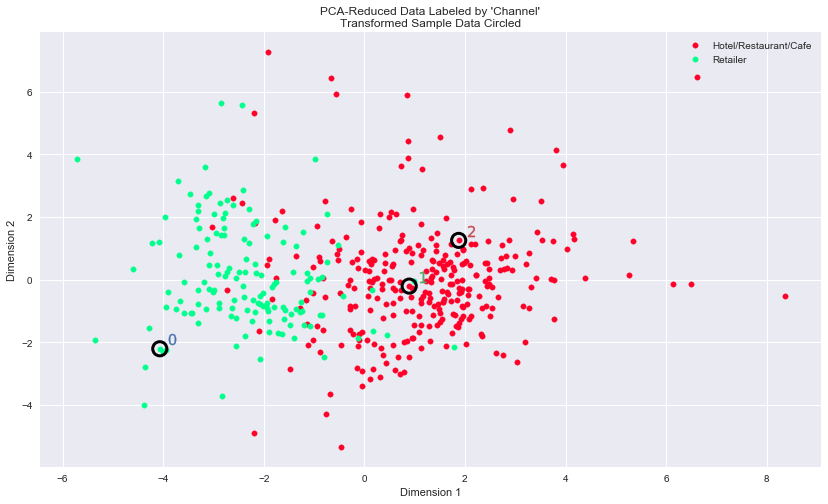

In [27]:
# Display the clustering results based on 'Channel' data
vs.channel_results(reduced_data, outliers, pca_samples)

The clustering algorithm and number of clusters I have chosen indicated that there are three clusters as opposed to two clusters in underlying distribution(Hotel/Restaurant/Cafe and Retailer). Segment 0 created by my clustering would be classified as purely 'Retailers' by this distribution barring a few exceptions.

My previous deffinition of customer segments is only partially consistent with this classification. According to my clustering there are three clusters which I considered as (1) grocery store (e.g., superstore; this mostly resembles retailers in underlying distribution), (2) vendors of fresh produce (but also carry small quantities of convinience items), and (3) cafes. My assumptions are shaped by my knowledge of how consumer market operates in my country. How consumer market is structured in Portugal may be entirely different. 



#### How would K-Means have performed?

I am curious how K-Means, a general purpose clustering algorithm would have performed. Could it correctly identify two clusters?


In [28]:
from sklearn.cluster import KMeans

def clustering_errors_2(k, data):
    kmeans = KMeans(n_clusters=k, random_state = 42).fit(data)
    predictions = kmeans.predict(data)
    silhouette_avg = silhouette_score(data, predictions)
    return silhouette_avg

possible_k_values = [2, 3, 4, 5, 7, 10, 20, 40, 70, 100, 150]

#calculate silhouette_score
sil_scores = [clustering_errors_2(k, reduced_data) for k in possible_k_values]

pd.DataFrame(list(zip(possible_k_values, sil_scores)), columns = ['n_components', 'Silhouette Score'])

,n_components,Silhouette Score
0,2,0.419166
1,3,0.393473
2,4,0.330322
3,5,0.346913
4,7,0.365685
5,10,0.350808
6,20,0.355912
7,40,0.356643
8,70,0.362422
9,100,0.372857


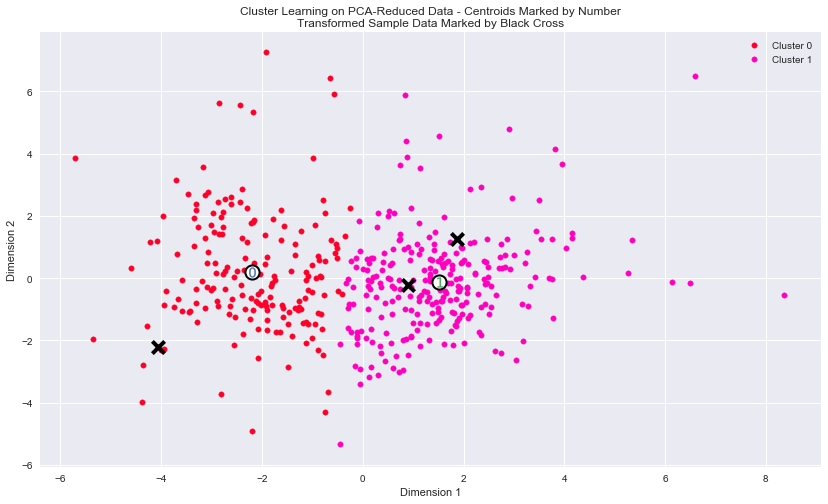

In [29]:
kmeans = KMeans(n_clusters=2).fit(reduced_data)

# Predict the cluster for each data point
preds = kmeans.predict(reduced_data)

# Find the cluster centers
centers = kmeans.cluster_centers_

# Display the results of the clustering from implementation
vs.cluster_results(reduced_data, preds, centers, pca_samples)


If I had selected KMeans instead of GMM, I would have picked k=2, based on Silhouette Score. That would have compared better to the underlying distribution of Hotel/Restaurant/Cafe customers and Retailer customers. However, in the absence of Channel data, I believe, there is nothing wrong with my decision to use GMM  given how this clustering results will be used by the wholesale distributor.

Furthermore, silhouette score for a given clustering algorithm vary from run to run. Even with gmm, in some runs, n_components = 2 produced better silhouette score than n_components = 3 when random_state arguement is left as None.

---
<a id='step10'></a>
## References
1. https://support.minitab.com/en-us/minitab/18/help-and-how-to/modeling-statistics/multivariate/how-to/principal-components/interpret-the-results/all-statistics-and-graphs/

2. https://www.quora.com/What-are-the-advantages-of-K-Means-clustering

3. https://classroom.udacity.com/nanodegrees/nd009t/parts/97af2e29-7ace-4288-8f00-7e7788c1c810/modules/d425790b-c3f4-4585-9e9b-299d608741df/lessons/75058ed7-ed1e-46b5-9aa2-3fe11da0d136/concepts/71a97c14-e970-47f0-9125-80d5ee5cfede

4. https://www.analyticsvidhya.com/blog/2016/11/an-introduction-to-clustering-and-different-methods-of-clustering/